## Generative Adversarial Networks
This notebook will build the most basic GAN possible. It will use 2 simple, fully-connected networks to learn how to draw a single digit ('3') from the MNIST dataset. 

First, get the dataset from the repository:

In [75]:
#Download the dataset from github

!git clone https://github.com/gregd190/Image-Classification---MNIST-Dataset---NN-Solutions
!cp -r Image-Classification---MNIST-Dataset---NN-Solutions/. /content/


fatal: destination path 'Image-Classification---MNIST-Dataset---NN-Solutions' already exists and is not an empty directory.


Import the necessary libraries:

In [0]:
#Import the necessary libraries

import numpy as np
import keras
import struct
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers


Preprocess the data:

In [0]:
# The MNIST data is provided in a file format that needs to be read before the data can be fed to the neural network. 
def read_data(image_filename, label_filename):
    
    #Create arrays to store labels and pixel data
    label_array = []
    image_array = []
    
    # Load everything in some numpy arrays
    with open(label_filename, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image_filename, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    for i in range(len(lbl)):
        label_array.append(lbl[i])
        image_array.append(img[i])
    
    #Convert arrays to np.arrays
    image_array = np.array(image_array)
    label_array = np.array(label_array)
    
    return(image_array, label_array)


Check that the data arrays look correct:

In [78]:
train_images, train_labels = read_data('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
print('Shape of train_labels = ',np.shape(train_labels))
print('Shape of train_images = ', np.shape(train_images))

print('train_labels[0:5] = ', train_labels[0:5])


Shape of train_labels =  (60000,)
Shape of train_images =  (60000, 28, 28)
train_labels[0:5] =  [5 0 4 1 9]


Find the array indexes of the number 5

In [79]:
threes_index = np.nonzero(train_labels==3)

#Test they are all 7's
print(train_labels[threes_index])

threes = train_images[threes_index]
np.shape(threes)



[3 3 3 ... 3 3 3]


(6131, 28, 28)

We have a training set of 6265 images of the digit 7.


Let's build the networks. 

In [80]:
def build_discriminator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i], activation = 'relu'))
        model.add(Dropout(0.3))
    
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

def build_generator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i], activation = 'relu'))
    
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

#Discriminator takes input of 784 pixels  
discriminator = build_discriminator_model((784,), 1, 1e-4, [2048,1024,512])

#Generator will take 100 inputs of random noise
generator = build_generator_model((100,), 784, 1e-5, [2048,1024,512]) 



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 513       
Total params: 4,231,169
Trainable params: 4,231,169
Non-trainable params: 0
_________________________________________________________________


In [0]:
def build_gan_model(discriminator, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(100,))
    # the output of the generator (an image)
    generated_image = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
    gan.compile(loss='binary_crossentropy', optimizer=adam)
    return gan

gan_model = build_gan_model(discriminator, generator) 

We need a way of determining whether to feed an image from the training set, or an image from the generator to the discriminator. We'll create a function that decides based on a 50:50 split

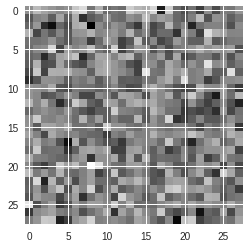

In [82]:
def plot_generated_image():
  noise = np.array([np.random.normal(0,1,100)])
  generated_image = generator.predict(noise)
  generated_image = generated_image.reshape(28, 28)
  
  return(generated_image)
  
#Test it - At this stage it should just be random pixels
plt.imshow(plot_generated_image(), interpolation='nearest', cmap='gray_r')


In [0]:
#Will return either a randomly generated image, or an image from the training set, plus either a 0 or 1, indicating whether the image is real(1) or generated(0)

def pick_image():
  if np.random.uniform() < 0.5:
    a = np.random.randint(0,len(threes))
    #print('TRUE IMAGE', np.shape(np.ndarray.flatten(threes[a])))
    return(np.reshape(threes[a],(1,784)),1)
  else:
    random_inputs = np.array([np.random.uniform(0,1,100)])
    generated_image = generator.predict(random_inputs)      
    #print('FAKE IMAGE', np.shape(generated_image))
    return(generated_image,0)

  

Now we need to feed our image into our discriminator model, and then train the two models based on the accuracy of the prediction:

In [0]:
def train(batches=1, batch_size=256):
    
    #Create a list to store images generated after every 100 batches
    generated_images = []
    
    for e in range(1, batches+1):
        #Print images every 1000 batches
        if e%2==0:
          print('After ', e,' batches:')
          plt.imshow(plot_generated_image(), cmap='gray_r')
          plt.show()
          
           
        #Initialize arrays for storage of images and labels for the entire batch
        images_array = []
        labels_array = []
        
        #Get images and labels
        for b in range(batch_size):
        
          image, label = pick_image()
          images_array.append(image)
          labels_array.append([label])
        
        images_array = np.array(images_array)
        images_array = np.reshape(images_array,(batch_size,784))
        labels_array = np.array(labels_array)
        
        # Train discriminator
        discriminator.trainable = True
        history = discriminator.fit(images_array, labels_array, verbose=False)
        discriminator_loss_history.append(history.history["loss"])

        # Train generator
        noise_array = np.random.normal(0,1,size=[batch_size,100])
        ones_array = np.ones((batch_size,1))
        
        discriminator.trainable = False
        history = gan_model.fit(noise_array, ones_array, verbose=False)
        gan_loss_history.append(history.history["loss"])
        
    return(generated_images)

# Initialise arrays to store the loss information during training.         
discriminator_loss_history = []
gan_loss_history = []




Train for 1500 batches to see how it performs.

After  2  batches:


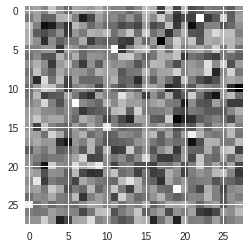

After  4  batches:


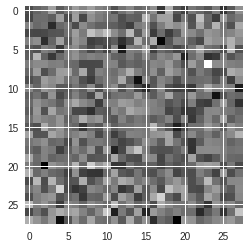

After  6  batches:


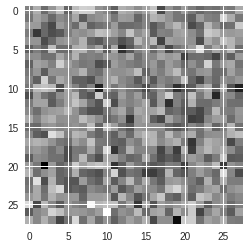

After  8  batches:


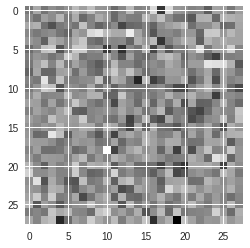

After  10  batches:


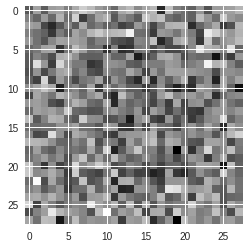

After  12  batches:


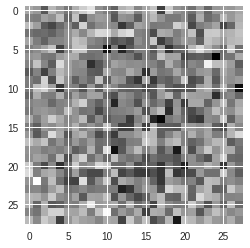

After  14  batches:


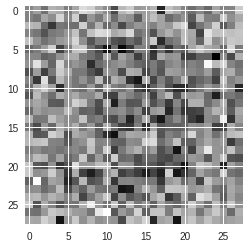

After  16  batches:


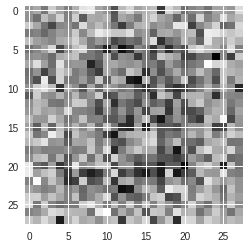

After  18  batches:


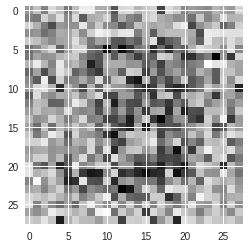

After  20  batches:


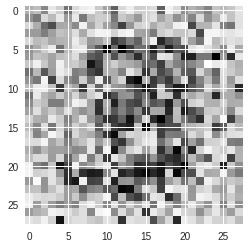

After  22  batches:


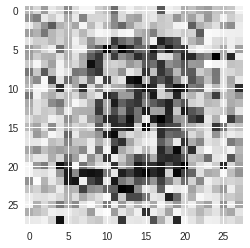

After  24  batches:


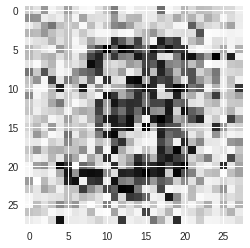

After  26  batches:


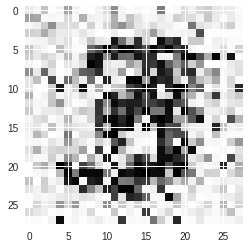

After  28  batches:


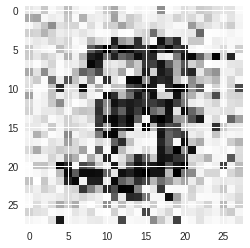

After  30  batches:


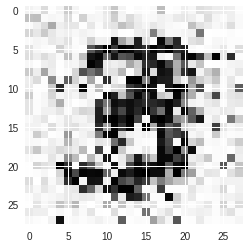

After  32  batches:


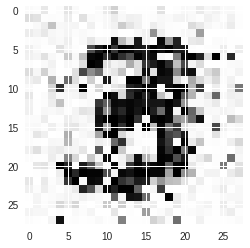

After  34  batches:


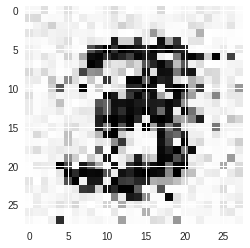

After  36  batches:


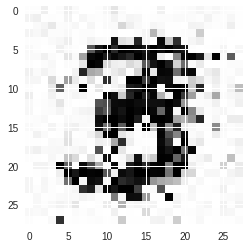

After  38  batches:


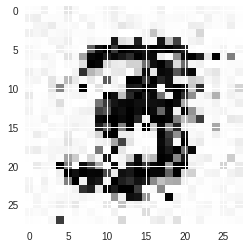

After  40  batches:


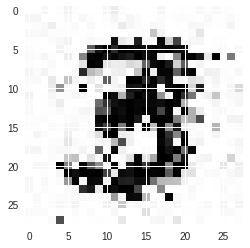

After  42  batches:


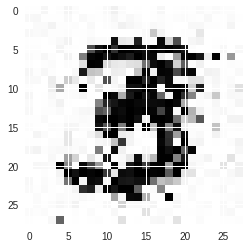

After  44  batches:


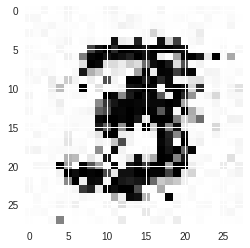

After  46  batches:


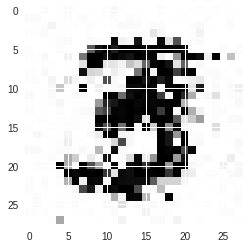

After  48  batches:


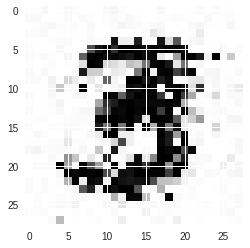

After  50  batches:


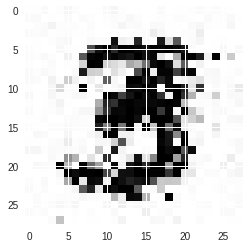

After  52  batches:


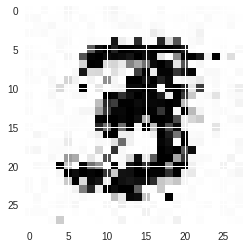

After  54  batches:


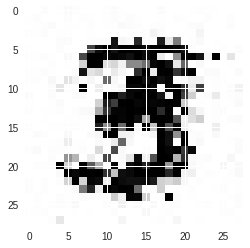

After  56  batches:


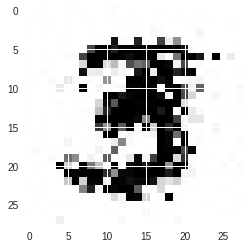

After  58  batches:


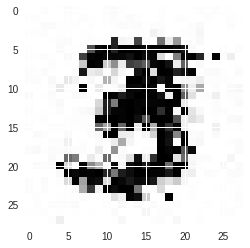

After  60  batches:


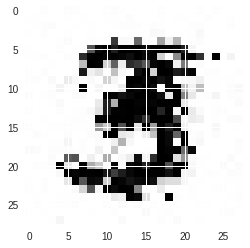

After  62  batches:


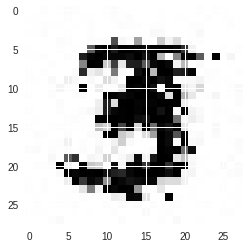

After  64  batches:


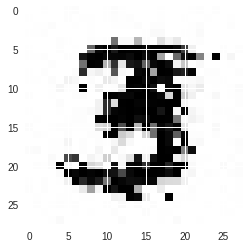

After  66  batches:


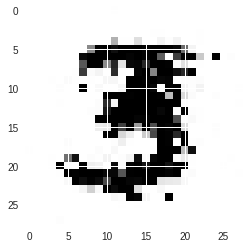

After  68  batches:


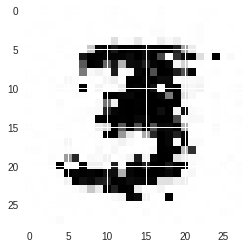

After  70  batches:


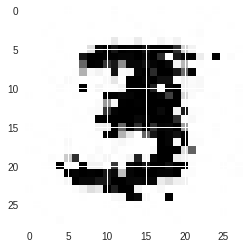

After  72  batches:


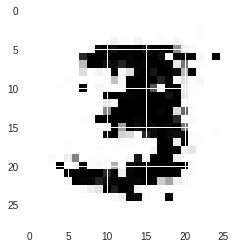

After  74  batches:


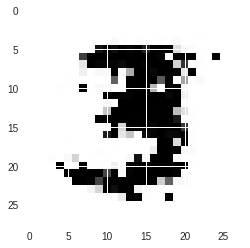

After  76  batches:


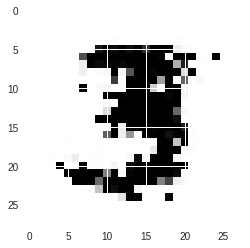

After  78  batches:


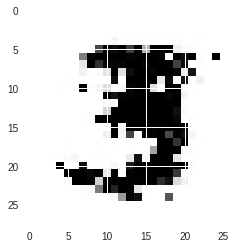

After  80  batches:


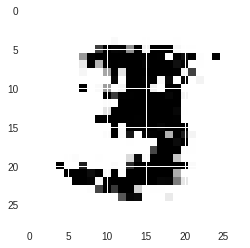

After  82  batches:


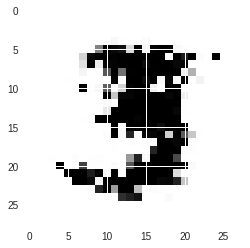

After  84  batches:


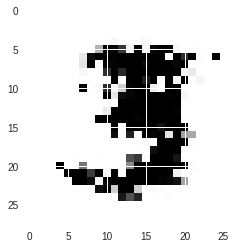

After  86  batches:


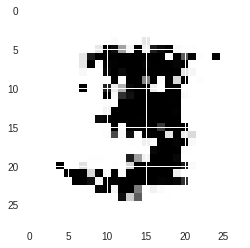

After  88  batches:


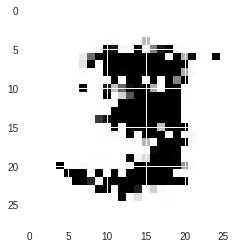

After  90  batches:


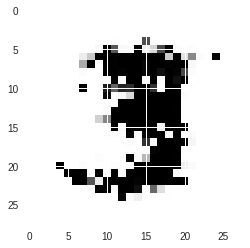

After  92  batches:


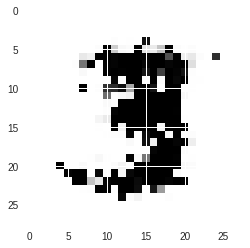

After  94  batches:


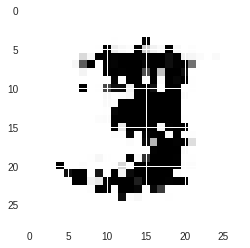

After  96  batches:


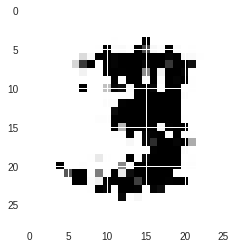

After  98  batches:


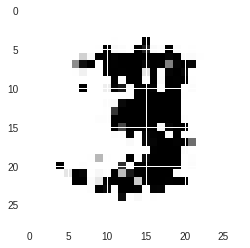

After  100  batches:


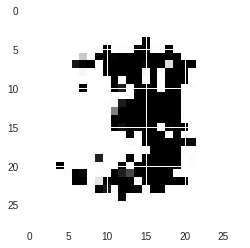

After  102  batches:


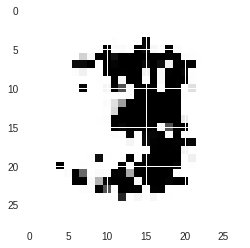

After  104  batches:


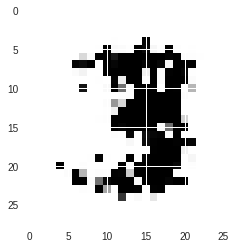

After  106  batches:


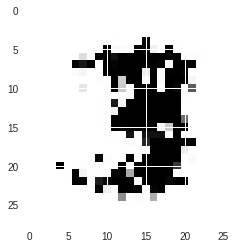

After  108  batches:


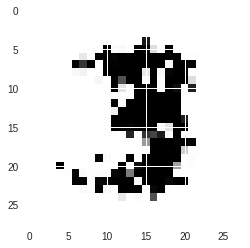

After  110  batches:


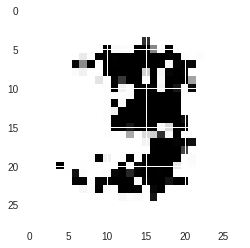

After  112  batches:


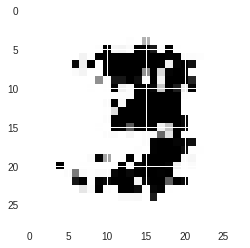

After  114  batches:


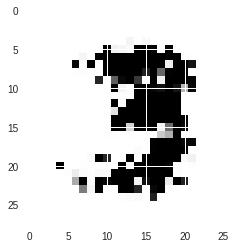

After  116  batches:


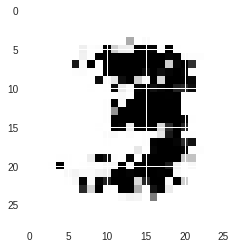

After  118  batches:


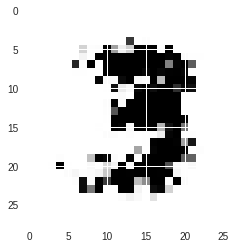

After  120  batches:


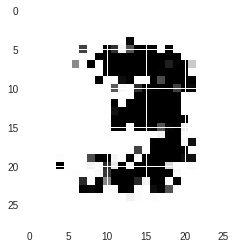

After  122  batches:


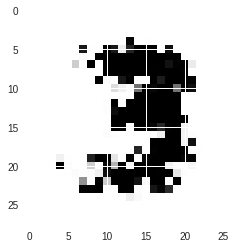

After  124  batches:


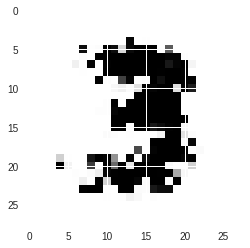

After  126  batches:


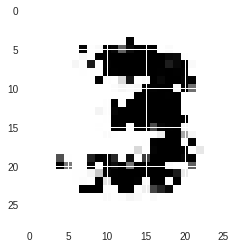

After  128  batches:


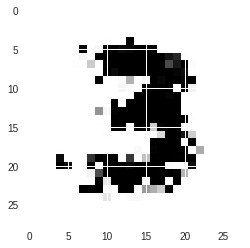

After  130  batches:


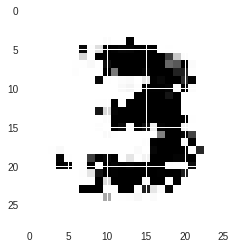

After  132  batches:


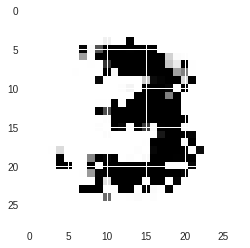

After  134  batches:


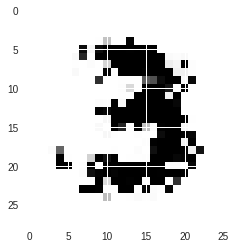

After  136  batches:


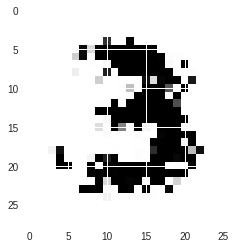

After  138  batches:


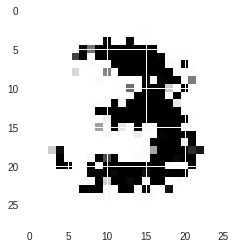

After  140  batches:


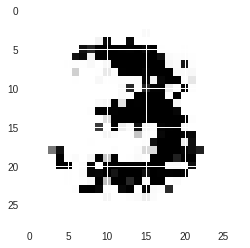

After  142  batches:


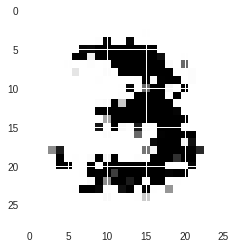

After  144  batches:


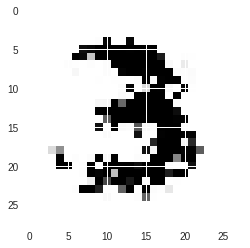

After  146  batches:


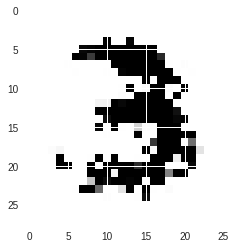

After  148  batches:


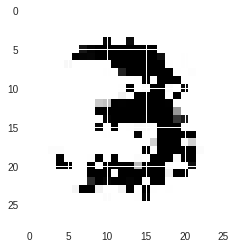

After  150  batches:


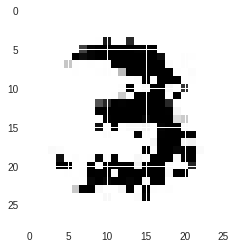

After  152  batches:


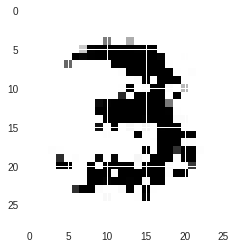

After  154  batches:


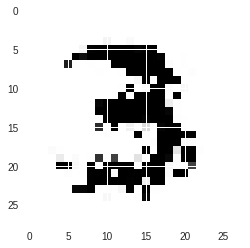

After  156  batches:


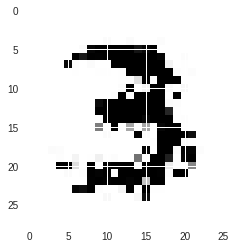

After  158  batches:


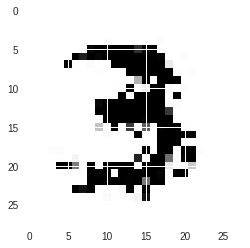

After  160  batches:


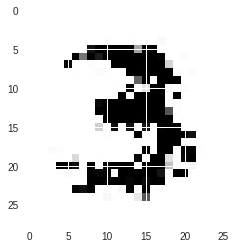

After  162  batches:


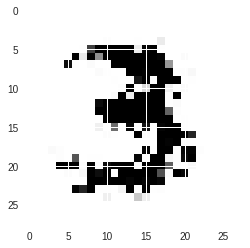

After  164  batches:


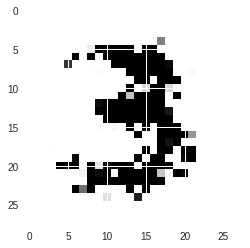

After  166  batches:


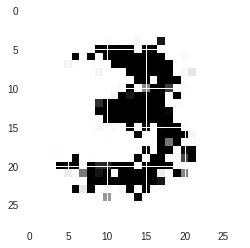

After  168  batches:


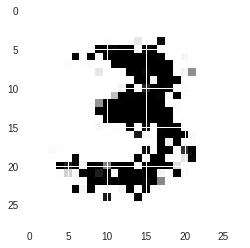

After  170  batches:


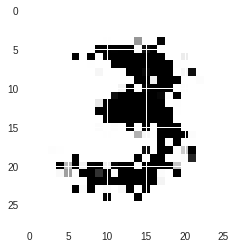

After  172  batches:


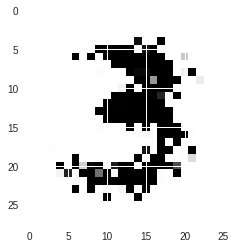

After  174  batches:


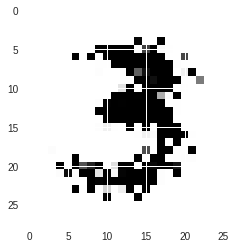

After  176  batches:


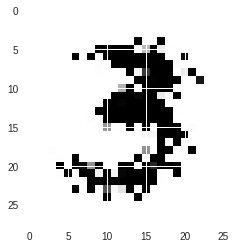

After  178  batches:


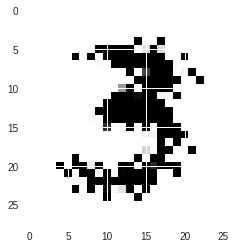

After  180  batches:


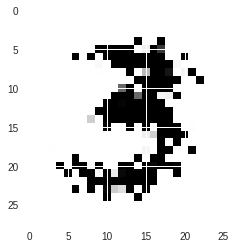

After  182  batches:


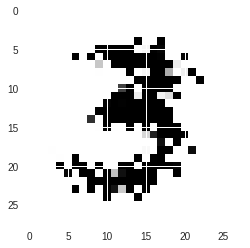

After  184  batches:


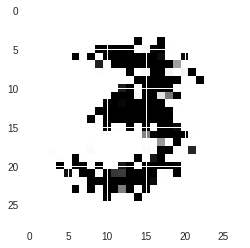

After  186  batches:


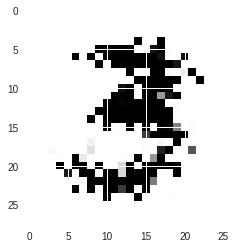

After  188  batches:


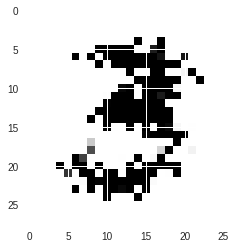

After  190  batches:


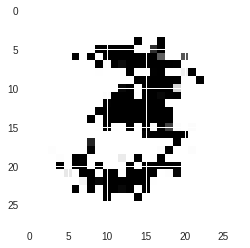

After  192  batches:


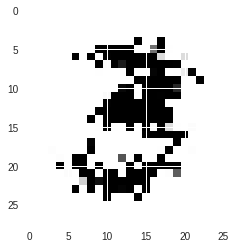

After  194  batches:


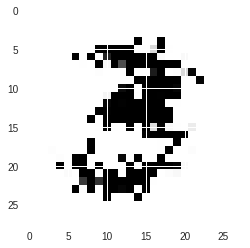

After  196  batches:


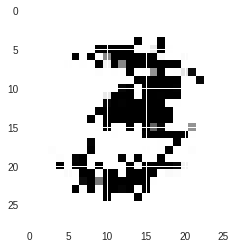

After  198  batches:


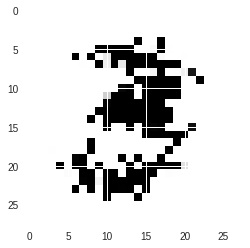

After  200  batches:


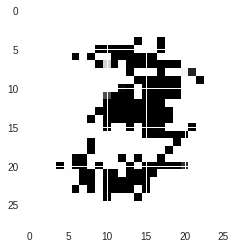

After  202  batches:


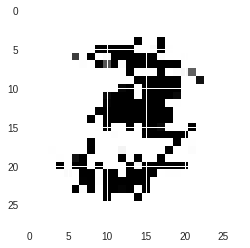

After  204  batches:


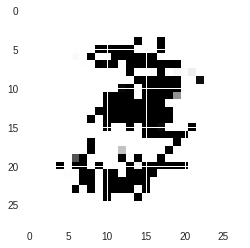

After  206  batches:


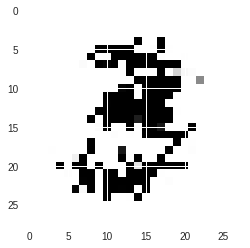

After  208  batches:


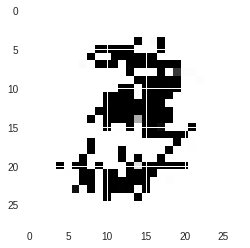

After  210  batches:


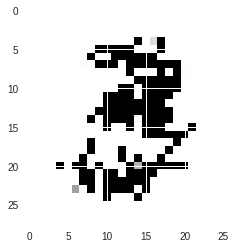

After  212  batches:


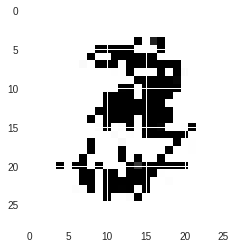

After  214  batches:


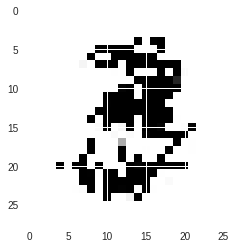

After  216  batches:


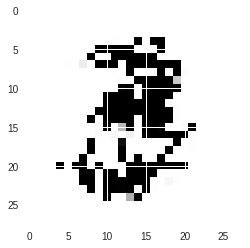

After  218  batches:


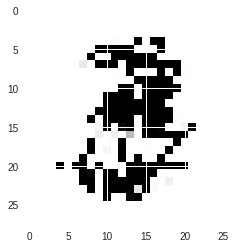

After  220  batches:


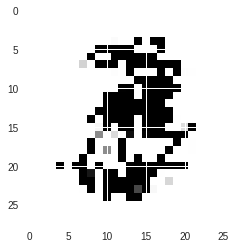

After  222  batches:


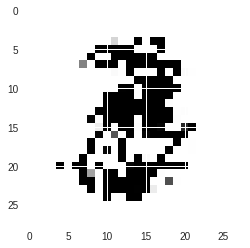

After  224  batches:


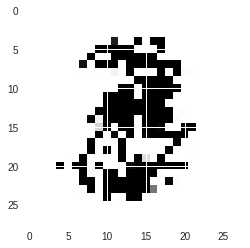

After  226  batches:


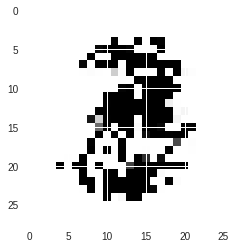

After  228  batches:


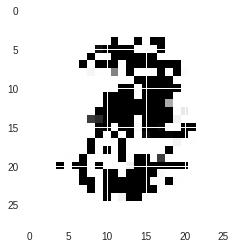

After  230  batches:


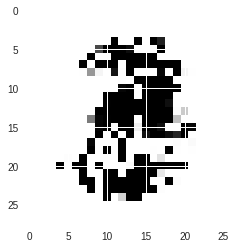

After  232  batches:


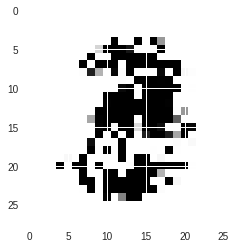

After  234  batches:


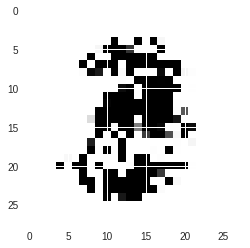

After  236  batches:


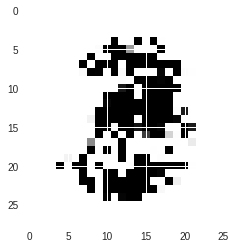

After  238  batches:


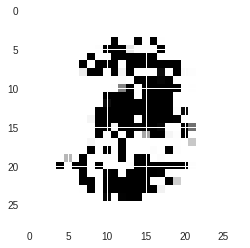

After  240  batches:


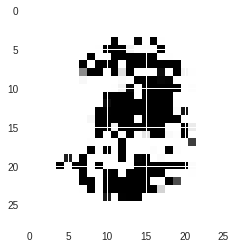

After  242  batches:


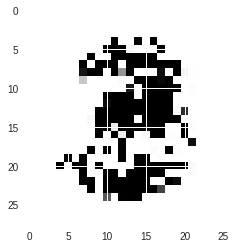

After  244  batches:


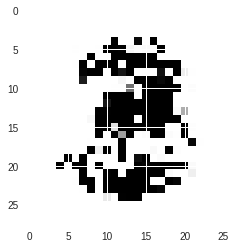

After  246  batches:


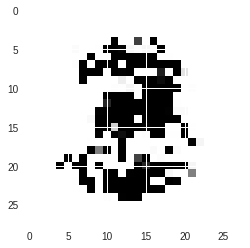

After  248  batches:


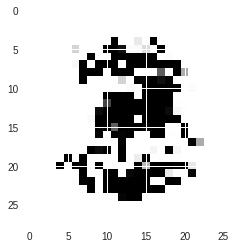

After  250  batches:


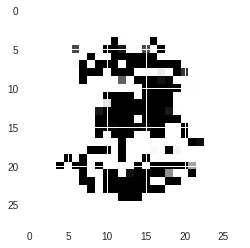

After  252  batches:


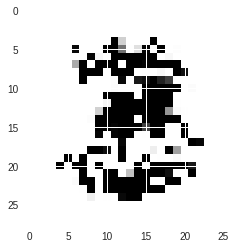

After  254  batches:


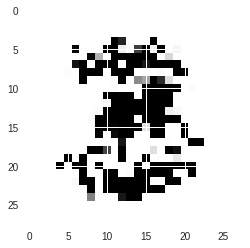

After  256  batches:


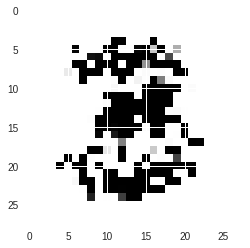

After  258  batches:


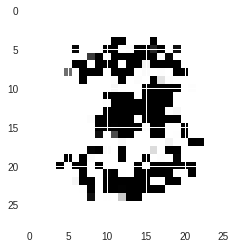

After  260  batches:


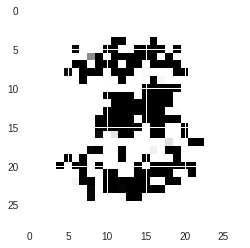

After  262  batches:


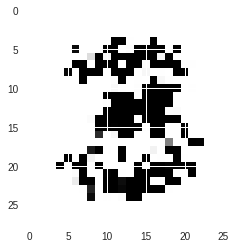

After  264  batches:


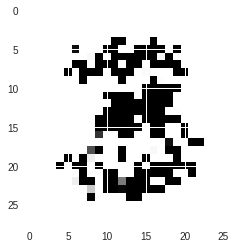

After  266  batches:


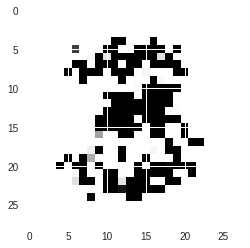

After  268  batches:


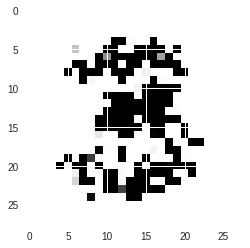

After  270  batches:


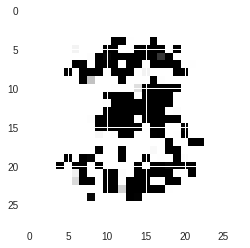

After  272  batches:


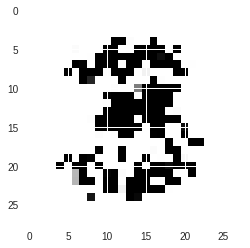

After  274  batches:


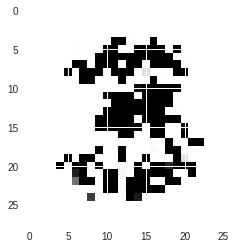

After  276  batches:


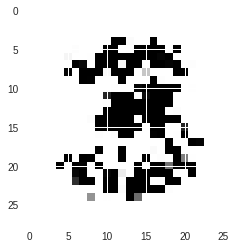

After  278  batches:


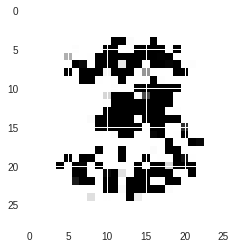

After  280  batches:


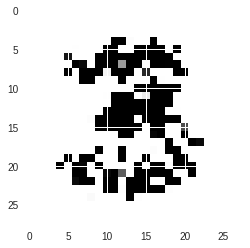

After  282  batches:


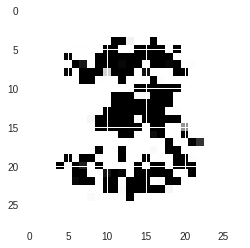

After  284  batches:


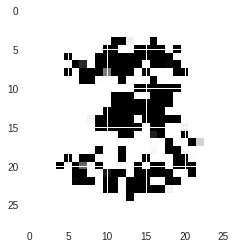

After  286  batches:


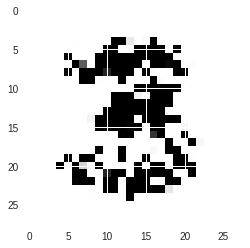

After  288  batches:


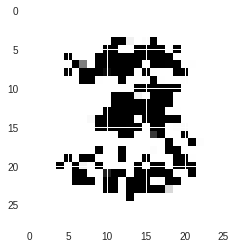

After  290  batches:


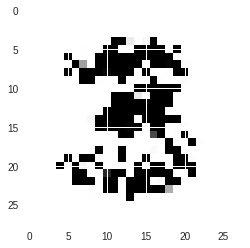

After  292  batches:


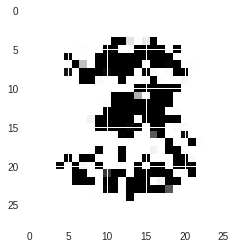

After  294  batches:


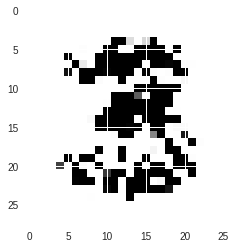

After  296  batches:


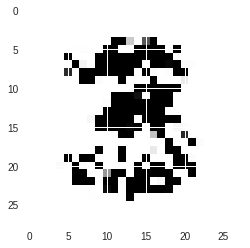

After  298  batches:


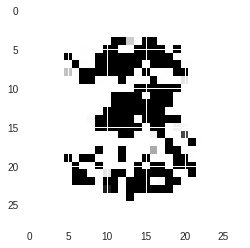

After  300  batches:


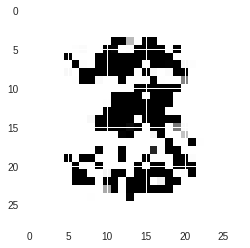

After  302  batches:


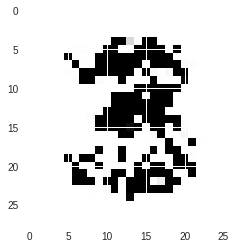

After  304  batches:


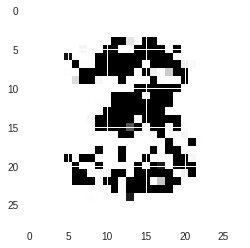

After  306  batches:


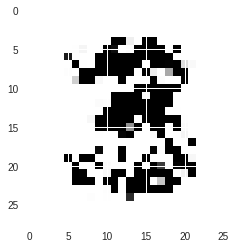

After  308  batches:


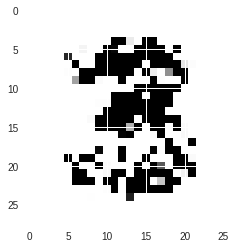

After  310  batches:


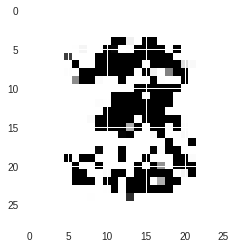

After  312  batches:


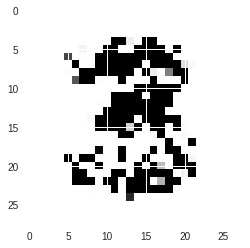

After  314  batches:


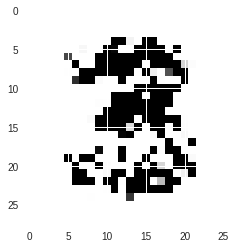

After  316  batches:


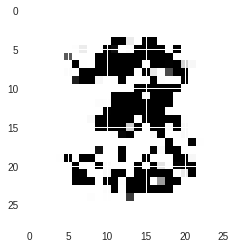

After  318  batches:


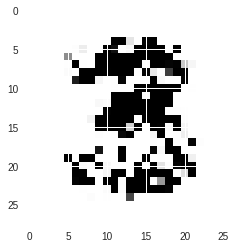

After  320  batches:


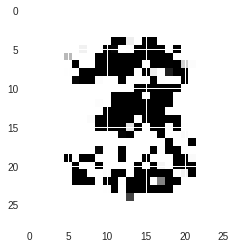

After  322  batches:


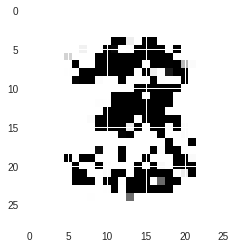

After  324  batches:


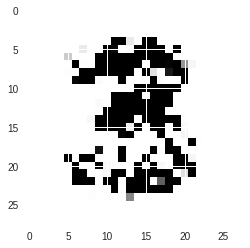

After  326  batches:


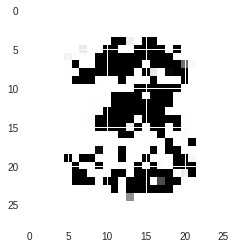

After  328  batches:


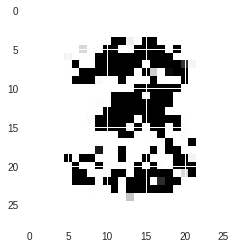

After  330  batches:


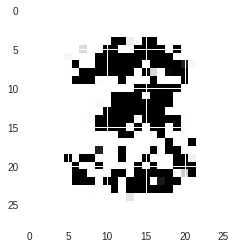

After  332  batches:


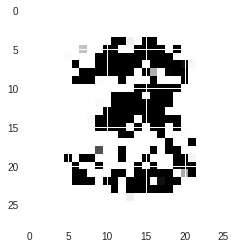

After  334  batches:


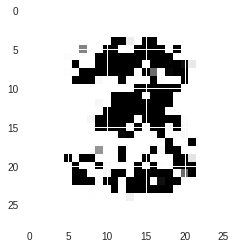

After  336  batches:


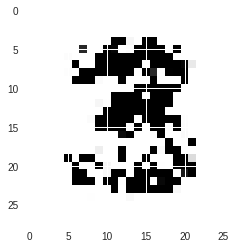

After  338  batches:


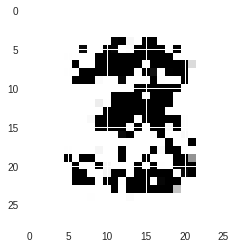

After  340  batches:


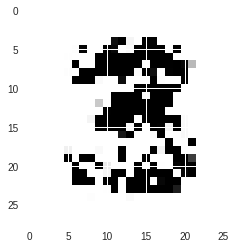

After  342  batches:


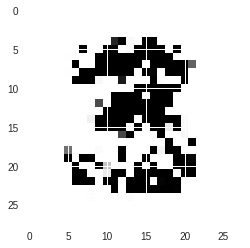

After  344  batches:


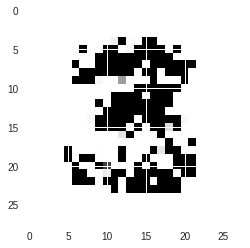

After  346  batches:


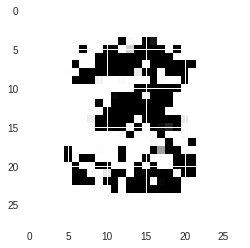

After  348  batches:


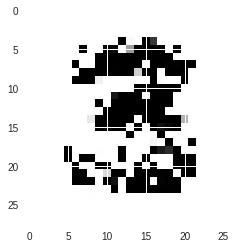

After  350  batches:


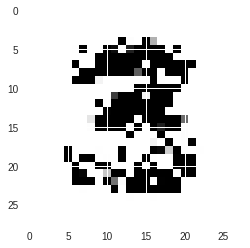

After  352  batches:


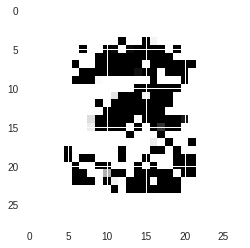

After  354  batches:


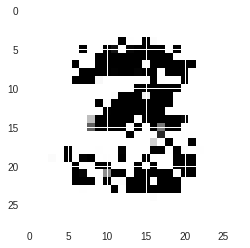

After  356  batches:


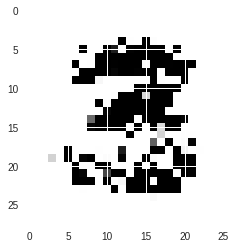

After  358  batches:


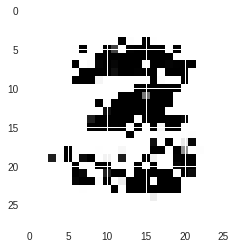

After  360  batches:


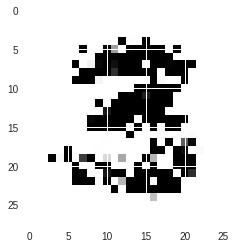

After  362  batches:


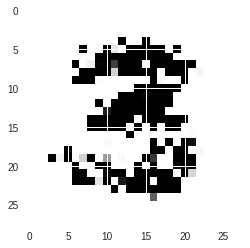

After  364  batches:


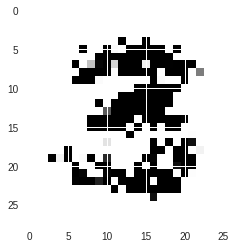

After  366  batches:


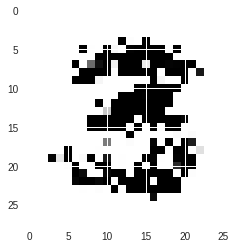

After  368  batches:


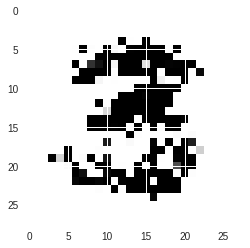

After  370  batches:


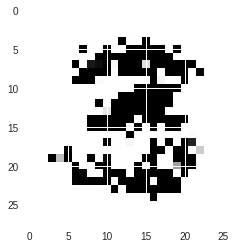

After  372  batches:


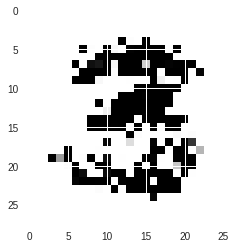

After  374  batches:


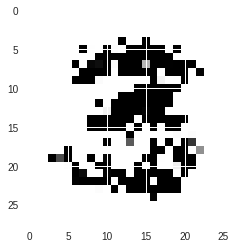

After  376  batches:


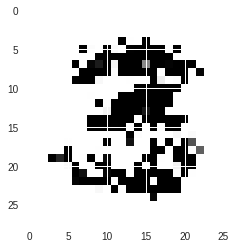

After  378  batches:


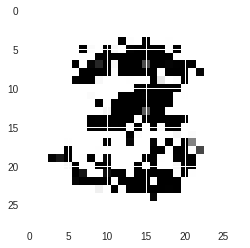

After  380  batches:


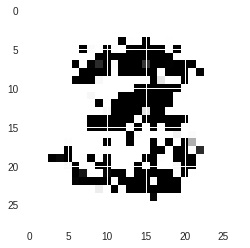

After  382  batches:


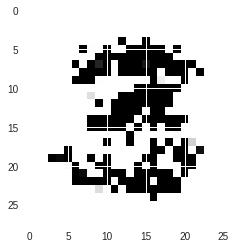

After  384  batches:


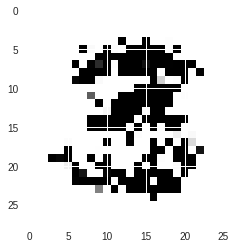

After  386  batches:


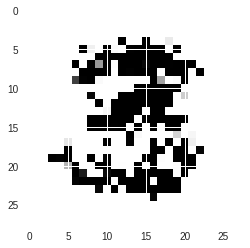

After  388  batches:


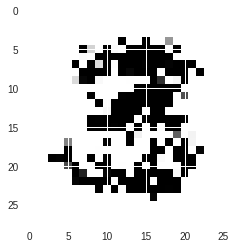

After  390  batches:


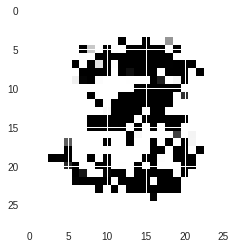

After  392  batches:


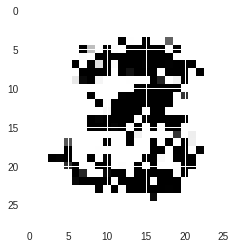

After  394  batches:


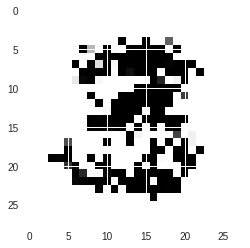

After  396  batches:


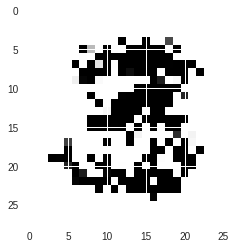

After  398  batches:


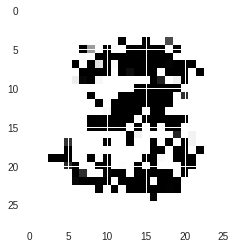

After  400  batches:


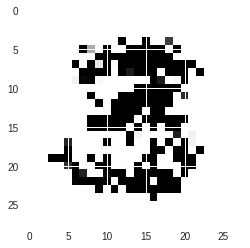

After  402  batches:


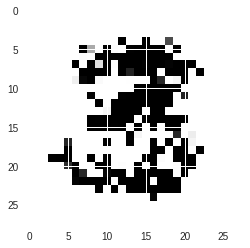

After  404  batches:


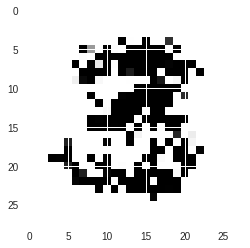

After  406  batches:


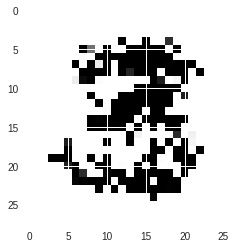

After  408  batches:


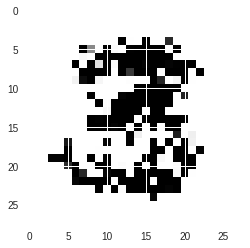

After  410  batches:


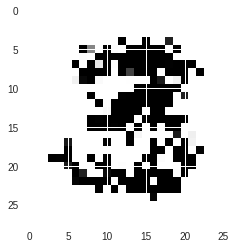

After  412  batches:


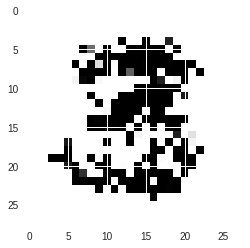

After  414  batches:


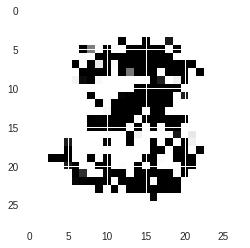

After  416  batches:


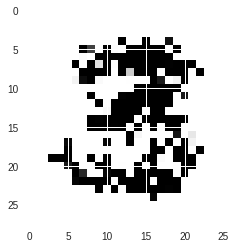

After  418  batches:


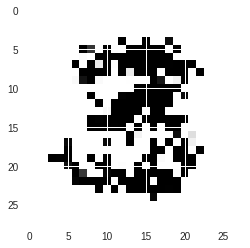

After  420  batches:


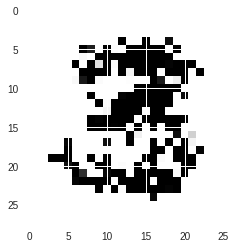

After  422  batches:


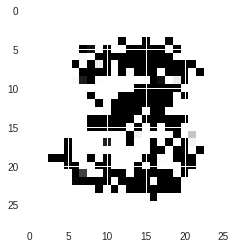

After  424  batches:


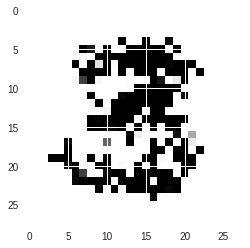

After  426  batches:


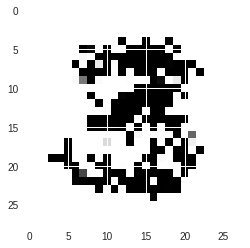

After  428  batches:


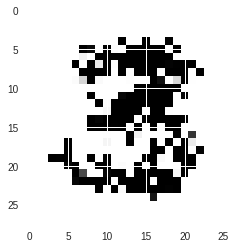

After  430  batches:


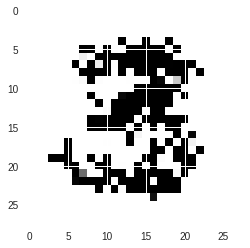

After  432  batches:


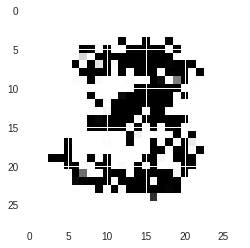

After  434  batches:


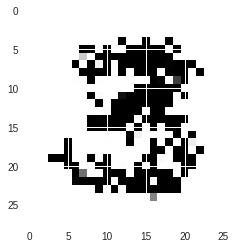

After  436  batches:


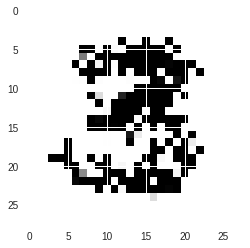

After  438  batches:


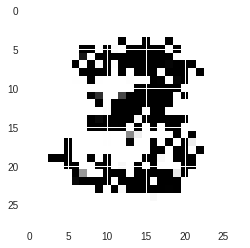

After  440  batches:


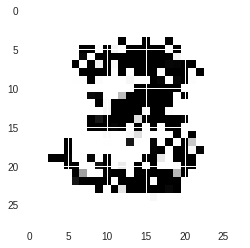

After  442  batches:


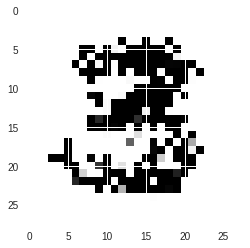

After  444  batches:


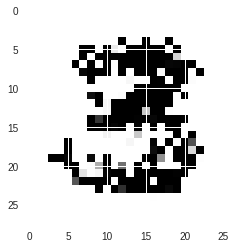

After  446  batches:


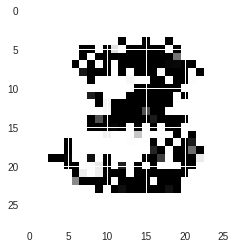

After  448  batches:


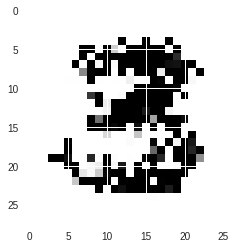

After  450  batches:


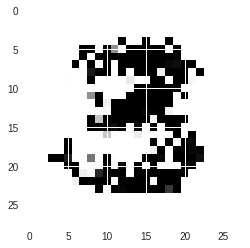

After  452  batches:


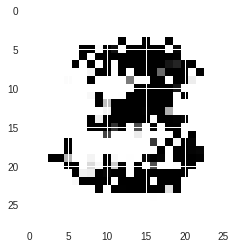

After  454  batches:


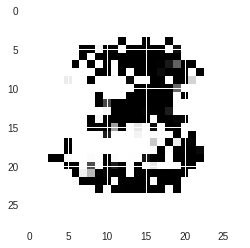

After  456  batches:


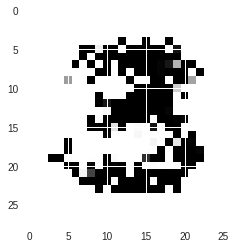

After  458  batches:


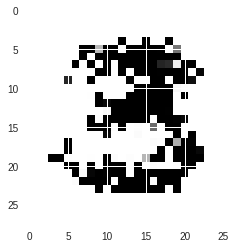

After  460  batches:


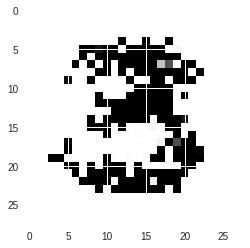

After  462  batches:


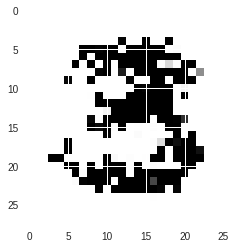

After  464  batches:


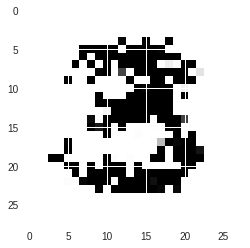

After  466  batches:


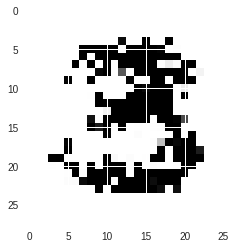

After  468  batches:


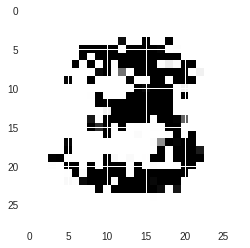

After  470  batches:


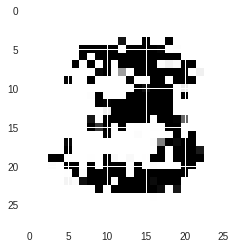

After  472  batches:


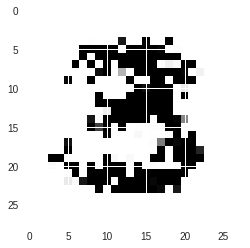

After  474  batches:


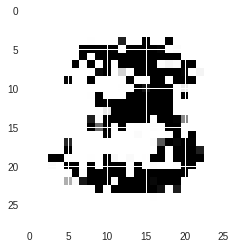

After  476  batches:


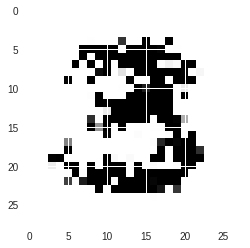

After  478  batches:


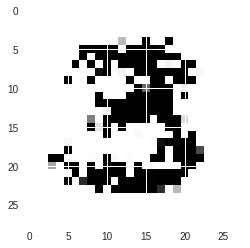

After  480  batches:


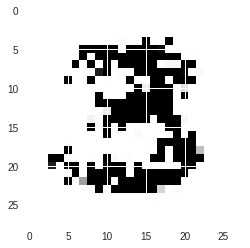

After  482  batches:


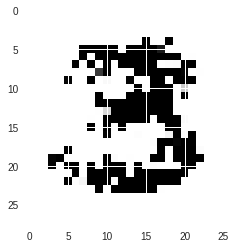

After  484  batches:


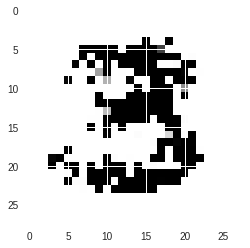

After  486  batches:


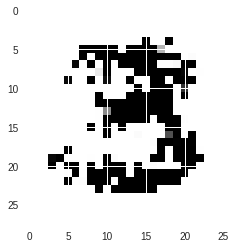

After  488  batches:


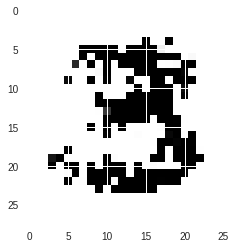

After  490  batches:


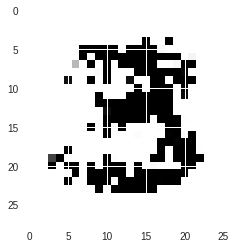

After  492  batches:


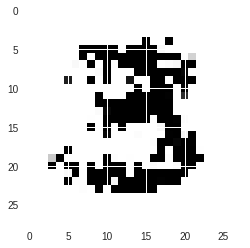

After  494  batches:


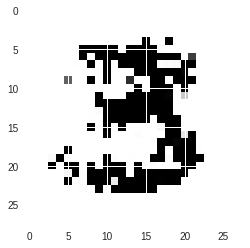

After  496  batches:


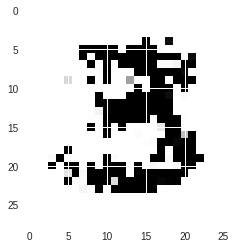

After  498  batches:


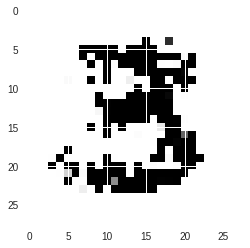

After  500  batches:


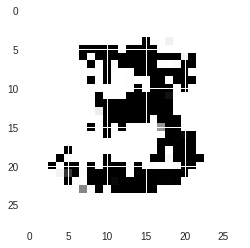

[]

In [85]:
train(500)



Plot the loss of the models vs training iterations to allow optimisation of the hyperparameters and to know when further training is unlikely to lead to further improvement.

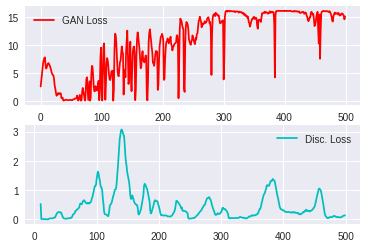

In [87]:
#Discriminator loss is extremely spiky. We'll smooth it to better see trends. 
discriminator_loss_rolling_avg =[]
discriminator_loss_iter_counter = []
for i in range(10,len(discriminator_loss_history)):
  discriminator_loss_rolling_avg.append(np.average(discriminator_loss_history[i-10:i]))
  discriminator_loss_iter_counter.append(i)
  
plt.subplot('211')
plt.plot(gan_loss_history,'r', label='GAN Loss')
plt.legend()
plt.subplot('212')
plt.plot(discriminator_loss_iter_counter,discriminator_loss_rolling_avg,'c', label='Disc. Loss')
plt.legend()
plt.show()

## Summary

A very simple generative adversarial network was trained to draw a single digit. This could easily be expanded to draw any digit by training on the entire MNIST dataset. It may be improved, either in final quality or by allowing training to occur over a smaller number of iterations through the implementation of a convolutional neural network.  